# Neural Networks: Introduction

**Исполнители (ФИО):** Your answer here

---

Здравствуйте, классическое Машинное Обучение подошло к концу. Далее вы познакомитесь с Введением в Глубокое Обучение и научитесь работать с полносвязными нейронными сетями прямого распространенния

`В данном блокноте вы будете работать с библиотекой PyTorch, для комфортной работы и чтобы не тратить время на установку, воспользуйтесь сервисом Google Collab, в которой этот инструмент уже предустановлен`

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Полносвязная нейронная сеть прямого распространения состоит из последовательных и связанным между собой слоев, каждый слой состоит из набора перцептронов (нейронов)

Перцептрон выражается формулой $f(\sum\limits_{i}w_{i}x_{i} + b)$, где $w_{i},b$ - веса, $x_{i}$ - входы, на первом слое - фичи, на последующих - выходы нейронов предыдущего слоя, $f$ - функция активации. Перцептрон является моделью линейной регрессии с нелинейной функцией активации

## Задача 1

Сгенерируйте данные $XOR$

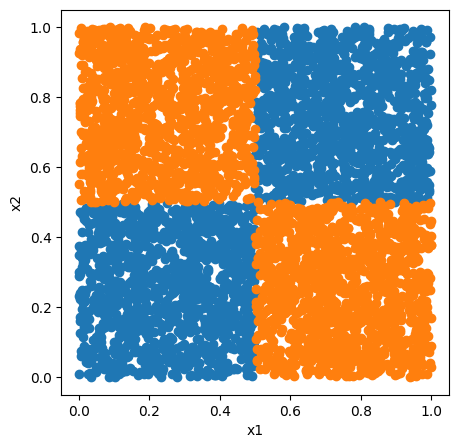

In [57]:
n_samples = 5000
X = np.random.rand(n_samples, 2).astype(float)
y = ((X[:, 0] > 0.5) ^ (X[:, 1] > 0.5)).astype(float).reshape(-1, 1)

plt.figure(figsize=(5, 5))
mask0 = (y.ravel() == 0)
mask1 = (y.ravel() == 1)
plt.scatter(X[mask0, 0], X[mask0, 1])
plt.scatter(X[mask1, 0], X[mask1, 1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float().reshape(-1, 1)

X_test_t = torch.from_numpy(X_test).float()
y_test_t = torch.from_numpy(y_test).float().reshape(-1, 1)

Создайте свой Перцептрон, используя пример ниже

In [58]:
# Пример Перцептрона

class Perceptron:

    def __init__(self, n_features, act):
        
        # инициализация весов и функции активации
        # requires_grad = True - для обучаемости весов (подсчета градиента)
        self.W = torch.normal(0, 0.1, (1, n_features), requires_grad = True)
        self.bias = torch.normal(0, 0.1, (1, 1), requires_grad = True)
        self.act = act

    def forward(self, x):
        
        # f(w* x + b)
        return self.act(torch.matmul(x, self.W.T) + self.bias)

    def parameters(self):
        return [self.W, self.bias]

In [59]:
n_features = X_train_t.shape[1]
perceptron = Perceptron(n_features=n_features, act=torch.sigmoid)

Чтобы обучить нейронную сеть, нужно 
1. посчитать предсказание
2. посчитать штраф (функцию потерь)
3. занулить градиент
4. посчитать градиент штрафа
5. сделать шаг градиентного спуска

Если вы хотите использовать возможности видеокарты для обучения, необходимо перенести обучаемые веса и данные на *GPU* с помощью метода *.to(device)*

In [61]:

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else :
    device = 'cpu'

print(device)
# train_data.to(device)

mps


In [62]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
def _meshgrid_from_data(X, n=300, pad=0.05):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    dx = (x_max - x_min) * pad
    dy = (y_max - y_min) * pad
    xs = np.linspace(x_min - dx, x_max + dx, n, dtype=np.float32)
    ys = np.linspace(y_min - dy, y_max + dy, n, dtype=np.float32)
    xx, yy = np.meshgrid(xs, ys)
    grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
    return xx, yy, grid

def _plot_base(X, y, title):
    y = y.ravel()
    plt.figure(figsize=(6, 6))
    plt.scatter(X[y == 0, 0], X[y == 0, 1], s=18, label="class 0")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], s=18, label="class 1")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")

def plot_boundary_torch(model, X, y, title, n=300, threshold=0.5):
    """
    model: Perceptron или PerceptronMod с методом forward(x) -> probs (0..1)
    X, y: numpy arrays (X: [N,2], y: [N,1] или [N,])
    """
    xx, yy, grid = _meshgrid_from_data(X, n=n)

    # модель из твоего кода почти наверняка на CPU; берём device у весов
    dev = model.W.device if hasattr(model, "W") else "cpu"

    with torch.no_grad():
        grid_t = torch.from_numpy(grid).to(dev)
        probs = model.forward(grid_t).detach().cpu().numpy().reshape(xx.shape)

    _plot_base(X, y, title)
    plt.contourf(xx, yy, probs, levels=30, alpha=0.35)
    plt.contour(xx, yy, probs, levels=[threshold])
    plt.legend()
    plt.show()

def plot_boundary_sklearn_proba(clf, X, y, title, n=300, threshold=0.5):

    xx, yy, grid = _meshgrid_from_data(X, n=n)
    probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

    _plot_base(X, y, title)
    plt.contourf(xx, yy, probs, levels=30, alpha=0.35)
    plt.contour(xx, yy, probs, levels=[threshold])
    plt.legend()
    plt.show()

Обычно градиент вычисляется последовательно не от всех данных, а по кусочкам, которые называют *batch*

Обучите Перцептрон на ваших данных, сравните результат с логистической регрессией. Постройте кривую обучения Перцептрона (зависимость функции потерь и метрики от эпохи на тренировочных и валидационных данных)

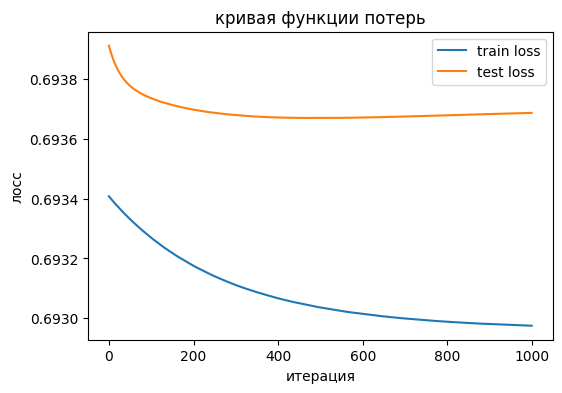

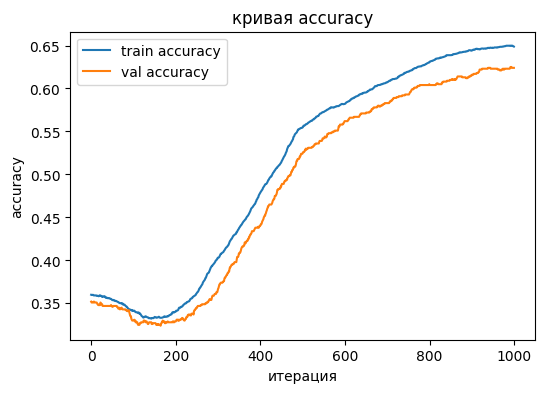

Perceptron:   train acc = 0.649, test acc = 0.624
LR: train acc = 0.649, test acc = 0.621


In [75]:
criterion = nn.BCELoss()
n_epochs = 1000
model = Perceptron(n_features=2, act=torch.sigmoid) 
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(n_epochs):
    y_pred_train = model.forward(X_train_t)
    loss_train = criterion(y_pred_train, y_train_t)
    
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    with torch.no_grad():
        y_train_cls = (y_pred_train >= 0.5).float()
        acc_train = (y_train_cls == y_train_t).float().mean().item()
        y_pred_test = model.forward(X_test_t)
        loss_test = criterion(y_pred_test, y_test_t)
        y_test_cls = (y_pred_test >= 0.5).float()
        acc_test = (y_test_cls == y_test_t).float().mean().item()
        
    train_losses.append(loss_train.item())
    test_losses.append(loss_test.item())
    train_accs.append(acc_train)
    test_accs.append(acc_test)


plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('итерация')
plt.ylabel('лосс')
plt.title('кривая функции потерь')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(train_accs, label='train accuracy')
plt.plot(test_accs, label='val accuracy')
plt.xlabel('итерация')
plt.ylabel('accuracy')
plt.title('кривая accuracy')
plt.legend()
plt.show()

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train.ravel())
y_train_lr = log_reg.predict(X_train)
y_test_lr = log_reg.predict(X_test)
acc_train_lr = accuracy_score(y_train.ravel(), y_train_lr)
acc_test_lr = accuracy_score(y_test.ravel(), y_test_lr)

print(f'Perceptron:   train acc = {train_accs[-1]:.3f}, test acc = {test_accs[-1]:.3f}')
print(f'LR: train acc = {acc_train_lr:.3f}, test acc = {acc_test_lr:.3f}')

Теперь попробуйте взять несколько перцептронов с разными начальными весами и собрать их в один слой (для измените класс *Perceptron*, чтобы он содержал несколько нейронов) 

Подумайте как аггрегировать вместе предсказания нескольких нейронов (слоя)

In [70]:
class PerceptronMod:
    
    def __init__(self, n_features, n_neurons, act_hidden=torch.tanh, act_out=torch.sigmoid):
        self.W = torch.normal(0, 0.1, (n_neurons, n_features), requires_grad=True)
        self.bias = torch.normal(0, 0.1, (n_neurons,), requires_grad=True)
        self.v = torch.normal(0, 0.1, (1, n_neurons), requires_grad=True)
        self.c = torch.normal(0, 0.1, (1, 1), requires_grad=True)
        self.act_hidden = act_hidden
        self.act_out = act_out

    def forward(self, x):
        h_lin = x @ self.W.T + self.bias          
        h = self.act_hidden(h_lin)              
        y_lin = h @ self.v.T + self.c      
        y = self.act_out(y_lin)               
        return y

    def parameters(self):
        return [self.W, self.bias, self.v, self.c]

In [73]:
criterion = nn.BCELoss()
n_epochs = 10000

n_hidden = 10
model_PM = PerceptronMod(n_features=n_features, n_neurons=n_hidden,
                        act_hidden=torch.tanh, act_out=torch.sigmoid)
optimizer = torch.optim.SGD(model_PM.parameters(), lr=0.01)

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(n_epochs):
    y_pred_train = model_PM.forward(X_train_t)
    loss_train = criterion(y_pred_train, y_train_t)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    with torch.no_grad():
        y_train_cls = (y_pred_train >= 0.5).float()
        acc_train = (y_train_cls == y_train_t).float().mean().item()

        y_pred_test = model_PM.forward(X_test_t)
        loss_test = criterion(y_pred_test, y_test_t)
        y_test_cls = (y_pred_test >= 0.5).float()
        acc_test = (y_test_cls == y_test_t).float().mean().item()

    train_losses.append(loss_train.item())
    test_losses.append(loss_test.item())
    train_accs.append(acc_train)
    test_accs.append(acc_test)


Сравните Перцептрон, Логистическую Регрессиию и Слой Перцептронов

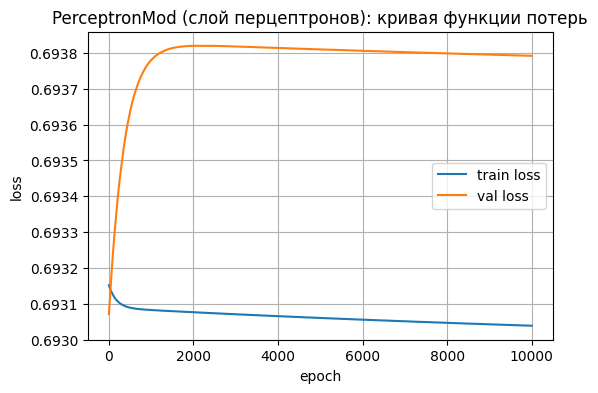

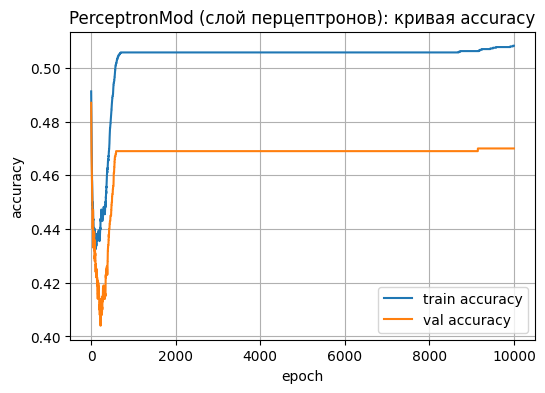

слой перцептронов — train acc = 0.508, test acc = 0.470


In [74]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('PerceptronMod (слой перцептронов): кривая функции потерь')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(train_accs, label='train accuracy')
plt.plot(test_accs, label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('PerceptronMod (слой перцептронов): кривая accuracy')
plt.legend()
plt.grid(True)
plt.show()

print(f'слой перцептронов — train acc = {train_accs[-1]:.3f}, test acc = {test_accs[-1]:.3f}')

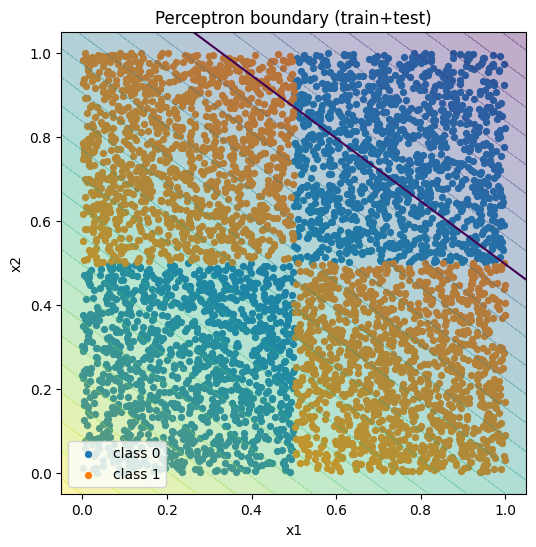

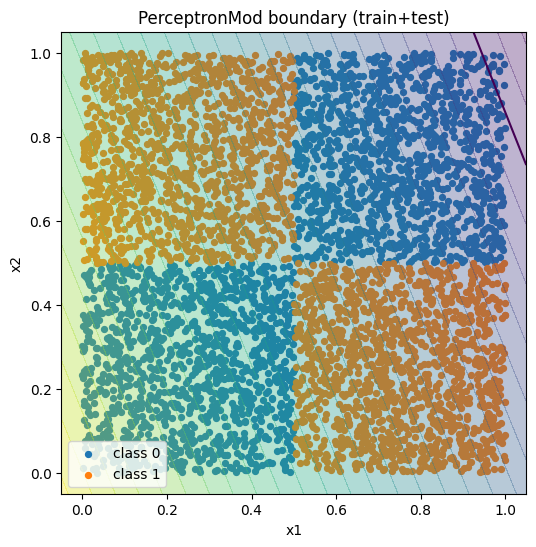

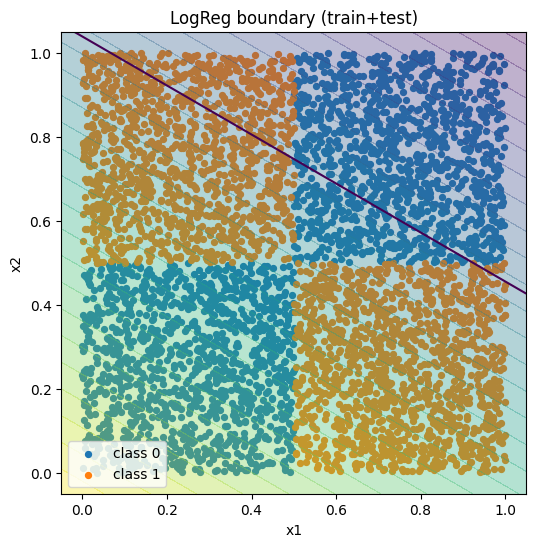

In [76]:
plot_boundary_torch(model, X, y, "Perceptron boundary (train+test)")
plot_boundary_torch(model_PM, X, y, "PerceptronMod boundary (train+test)")
plot_boundary_sklearn_proba(log_reg, X, y, "LogReg boundary (train+test)")

**Вопрос:** Какая модель оказалась лучше? Есть ли различие в их работе? Предположите, почему?

*Your answer here*

## Задача 2

In [77]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.flatten = nn.Flatten()

        # n_i количество перцептронов на i слое
        # соответствует количеству входов на i + 1 слое
        self.layers_stack = nn.Sequential(
            nn.Linear(n_features, n1),
            nn.ReLU(), # функция активации после первого слоя
            nn.Linear(n1, n2),
            nn.ReLU(), # функция активации после второго слоя
            nn.Linear(n2, n_classes)
        )

    def forward(self, x):
        x = self.flatten(x) # делаем данные плоскоми
        logits = self.layers_stack(x) # применяем последовательно слои
        return logits

Загрузите датасет *richters_whole_1.csv*

In [78]:
df = pd.read_csv("richters_whole_1.csv")
df = df.drop(columns=["Unnamed: 0"])
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
y_raw = df["damage_grade"].values
X2 = df.drop(columns=cat_cols + ["damage_grade"]).astype("float32").values
classes, y_encoded = np.unique(y_raw, return_inverse=True)
y2 = y_encoded.astype(np.int64)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2,test_size=0.3,random_state=None,stratify=y2)

Постройте полносвязную нейронную сеть, используя пример выше, для классификации на ваших данных

In [84]:
print("X2_train:", X2_train.shape, X2_train.dtype, "min/max:", X2_train.min(), X2_train.max())
print("y2_train:", y2_train.shape, y2_train.dtype, "unique:", len(np.unique(y2_train)))
print("y2_train min/max:", np.min(y2_train), np.max(y2_train))
print("y2_test  min/max:", np.min(y2_test),  np.max(y2_test))

# если вдруг one-hot:
print("y2_train ndim:", np.ndim(y2_train))

X2_train: (12250, 31) float32 min/max: 0.0 1052908.0
y2_train: (12250,) int64 unique: 3
y2_train min/max: 0 2
y2_test  min/max: 0 2
y2_train ndim: 1


In [89]:
from sklearn.preprocessing import StandardScaler

# тк фичи неотрицательные и с огромным хвостом, то так можно)
X2_train = np.log1p(X2_train)
X2_test  = np.log1p(X2_test)

scaler = StandardScaler()
X2_train = scaler.fit_transform(X2_train).astype(np.float32)
X2_test  = scaler.transform(X2_test).astype(np.float32)

Epoch 10/500, train loss = 1.0919, test loss = 1.0835, train acc = 0.335, test acc = 0.394
Epoch 20/500, train loss = 1.0092, test loss = 1.0011, train acc = 0.563, test acc = 0.565
Epoch 30/500, train loss = 0.9390, test loss = 0.9327, train acc = 0.568, test acc = 0.568
Epoch 40/500, train loss = 0.8873, test loss = 0.8821, train acc = 0.568, test acc = 0.568
Epoch 50/500, train loss = 0.8487, test loss = 0.8441, train acc = 0.569, test acc = 0.569
Epoch 60/500, train loss = 0.8255, test loss = 0.8211, train acc = 0.571, test acc = 0.574
Epoch 70/500, train loss = 0.8139, test loss = 0.8089, train acc = 0.574, test acc = 0.579
Epoch 80/500, train loss = 0.8062, test loss = 0.8017, train acc = 0.583, test acc = 0.584
Epoch 90/500, train loss = 0.8007, test loss = 0.7970, train acc = 0.585, test acc = 0.586
Epoch 100/500, train loss = 0.7966, test loss = 0.7936, train acc = 0.589, test acc = 0.588
Epoch 110/500, train loss = 0.7933, test loss = 0.7911, train acc = 0.592, test acc = 0.5

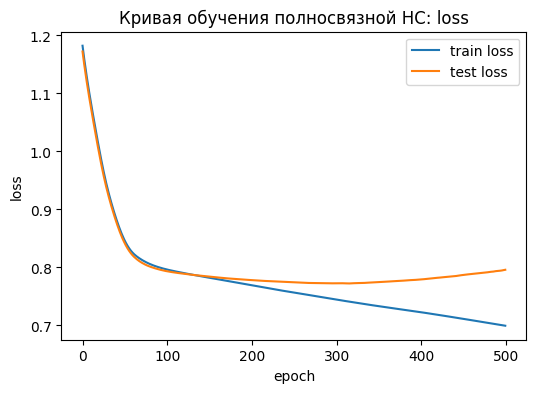

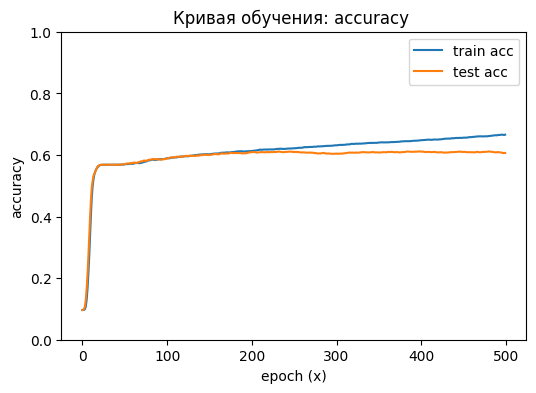

In [91]:
n_features = X2_train.shape[1]
n1 = 64
n2 = 32
n_classes = len(np.unique(y2_train))

model2 = SimpleNeuralNetwork().to(device)

criterion2 = nn.CrossEntropyLoss().to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

n_epochs2 = 500

X2_train_t = torch.from_numpy(X2_train).to(device)
y2_train_t = torch.from_numpy(y2_train).to(device)

X2_test_t = torch.from_numpy(X2_test).to(device)
y2_test_t = torch.from_numpy(y2_test).to(device)

train_losses2 = []
test_losses2 = []

train_accs2   = []
test_accs2    = []

for epoch in range(n_epochs2):
    model2.train()
    logits_train = model2(X2_train_t)
    loss_train = criterion2(logits_train, y2_train_t)

    optimizer2.zero_grad()
    loss_train.backward()
    optimizer2.step()

    model2.eval()
    with torch.no_grad():
        logits_test = model2(X2_test_t)
        loss_test = criterion2(logits_test, y2_test_t)

        train_pred = logits_train.argmax(dim=1)   # logits_train ок, это "после шага" не принципиально
        test_pred  = logits_test.argmax(dim=1)

        train_acc = (train_pred == y2_train_t).float().mean().item()
        test_acc  = (test_pred  == y2_test_t).float().mean().item()

    train_losses2.append(loss_train.item())
    test_losses2.append(loss_test.item())
    train_accs2.append(train_acc)
    test_accs2.append(test_acc)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs2}, "
              f"train loss = {loss_train.item():.4f}, "
              f"test loss = {loss_test.item():.4f}, "
              f"train acc = {train_acc:.3f}, "
              f"test acc = {test_acc:.3f}")

plt.figure(figsize=(6, 4))
plt.plot(train_losses2, label="train loss")
plt.plot(test_losses2, label="test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Кривая обучения полносвязной НС: loss")
plt.legend()
plt.show()


plt.figure(figsize=(6,4))
plt.plot(train_accs2, label="train acc")
plt.plot(test_accs2, label="test acc")
plt.ylim(0, 1)
plt.xlabel(f"epoch (x)"); plt.ylabel("accuracy")
plt.title("Кривая обучения: accuracy ")
plt.legend()
plt.show()

Попробуйте разные архитектуры нейронной сети, произвольно меняя параметры: 
1. количество слоев
2. количество перцептронов в слое
3. функции активации слоя

Постройте кривую обучения Нейронной сети (зависимость функции потерь и метрики от эпохи на тренировочных и валидационных данных)

In [ ]:
class NeuralNetworkAlt(nn.Module):
    def __init__(self, n_features, n1, n2, n3, n_classes, act_hidden):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(n_features, n1),
            act_hidden,
            nn.Linear(n1, n2),
            act_hidden,
            nn.Linear(n2, n3),
            act_hidden,
            nn.Linear(n3, n_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.layers_stack(x)

[ALT] Epoch 10/500, train loss = 0.9912, test loss = 0.9829, train acc = 0.568, test acc = 0.568
[ALT] Epoch 20/500, train loss = 0.9040, test loss = 0.8964, train acc = 0.568, test acc = 0.568
[ALT] Epoch 30/500, train loss = 0.8358, test loss = 0.8262, train acc = 0.568, test acc = 0.568
[ALT] Epoch 40/500, train loss = 0.8127, test loss = 0.8031, train acc = 0.582, test acc = 0.586
[ALT] Epoch 50/500, train loss = 0.8006, test loss = 0.7942, train acc = 0.586, test acc = 0.584
[ALT] Epoch 60/500, train loss = 0.7935, test loss = 0.7891, train acc = 0.589, test acc = 0.587
[ALT] Epoch 70/500, train loss = 0.7867, test loss = 0.7853, train acc = 0.595, test acc = 0.591
[ALT] Epoch 80/500, train loss = 0.7789, test loss = 0.7821, train acc = 0.604, test acc = 0.597
[ALT] Epoch 90/500, train loss = 0.7702, test loss = 0.7794, train acc = 0.611, test acc = 0.600
[ALT] Epoch 100/500, train loss = 0.7607, test loss = 0.7775, train acc = 0.617, test acc = 0.596
[ALT] Epoch 110/500, train lo

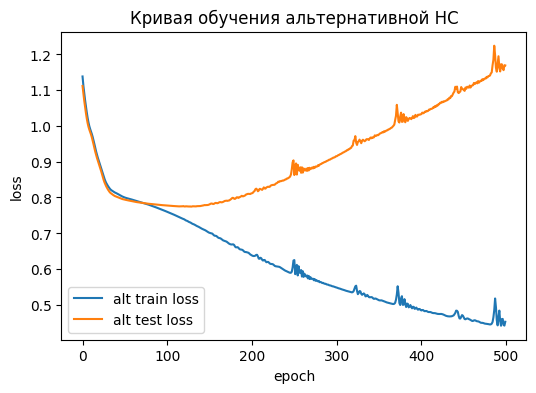

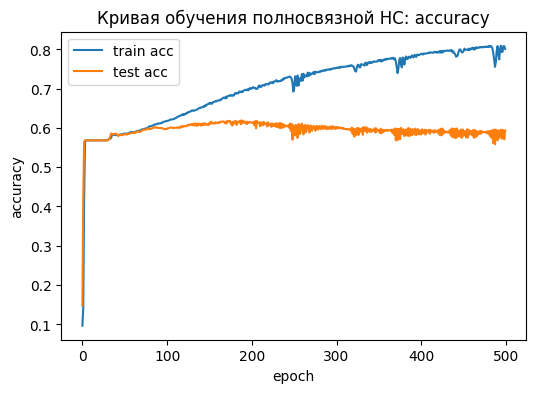

In [97]:

n1_alt = 256
n2_alt = 128
n3_alt = 65
act_alt = nn.LeakyReLU(negative_slope=0.01)

model_alt = NeuralNetworkAlt(n_features, n1_alt, n2_alt, n3_alt, n_classes, act_alt).to(device)

criterion_alt = nn.CrossEntropyLoss().to(device)
optimizer_alt = torch.optim.Adam(model_alt.parameters(), lr=0.001)

n_epochs_alt = 500

train_losses_alt = []
test_losses_alt = []
train_accs_alt = []
test_accs_alt = []

for epoch in range(n_epochs_alt):
    logits_train_alt = model_alt(X2_train_t)
    loss_train_alt = criterion_alt(logits_train_alt, y2_train_t)

    optimizer_alt.zero_grad()
    loss_train_alt.backward()
    optimizer_alt.step()

    with torch.no_grad():
        logits_test_alt = model_alt(X2_test_t)
        loss_test_alt = criterion_alt(logits_test_alt, y2_test_t)

    train_losses_alt.append(loss_train_alt.item())
    test_losses_alt.append(loss_test_alt.item())
    _, train_pred_alt = torch.max(logits_train_alt, 1)
    _, test_pred_alt = torch.max(logits_test_alt, 1)
    train_acc_alt = (train_pred_alt == y2_train_t).float().mean().item()
    test_acc_alt = (test_pred_alt == y2_test_t).float().mean().item()
    train_accs_alt.append(train_acc_alt)
    test_accs_alt.append(test_acc_alt)
    if (epoch + 1) % 10 == 0:
        print(f"[ALT] Epoch {epoch+1}/{n_epochs_alt}, "
              f"train loss = {loss_train_alt.item():.4f}, "
              f"test loss = {loss_test_alt.item():.4f}, "
              f"train acc = {train_acc_alt:.3f}, "
              f"test acc = {test_acc_alt:.3f}")

with torch.no_grad():
    logits_test_alt = model_alt(X2_test_t)
    _, y2_pred_alt = torch.max(logits_test_alt, 1)
    acc_alt = (y2_pred_alt == y2_test_t).float().mean().item()

print(f"\nAccuracy для альтернативной архитектуры: {acc_alt:.3f}")

plt.figure(figsize=(6, 4))
plt.plot(train_losses_alt, label="alt train loss")
plt.plot(test_losses_alt, label="alt test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Кривая обучения альтернативной НС")
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(train_accs_alt, label="train acc")
plt.plot(test_accs_alt, label="test acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Кривая обучения полносвязной НС: accuracy")
plt.legend()
plt.show()

In [94]:
class NeuralNetworkDP(nn.Module):
    def __init__(self, n_features, n1, n2, n3, n_classes, act_hidden):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(n_features, n1),
            act_hidden,
            nn.Dropout(p=0.5),
            nn.Linear(n1, n2),
            act_hidden,
            nn.Dropout(p=0.5),
            nn.Linear(n2, n3),
            act_hidden,
            nn.Dropout(p=0.5),
            nn.Linear(n3, n_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.layers_stack(x)

[ALT] Epoch 10/500, train loss = 0.9714, test loss = 0.9635, train acc = 0.567, test acc = 0.566
[ALT] Epoch 20/500, train loss = 0.8935, test loss = 0.8805, train acc = 0.541, test acc = 0.544
[ALT] Epoch 30/500, train loss = 0.8476, test loss = 0.8483, train acc = 0.567, test acc = 0.553
[ALT] Epoch 40/500, train loss = 0.8402, test loss = 0.8400, train acc = 0.558, test acc = 0.570
[ALT] Epoch 50/500, train loss = 0.8287, test loss = 0.8240, train acc = 0.564, test acc = 0.572
[ALT] Epoch 60/500, train loss = 0.8234, test loss = 0.8142, train acc = 0.570, test acc = 0.577
[ALT] Epoch 70/500, train loss = 0.8158, test loss = 0.8140, train acc = 0.571, test acc = 0.571
[ALT] Epoch 80/500, train loss = 0.8129, test loss = 0.8179, train acc = 0.574, test acc = 0.577
[ALT] Epoch 90/500, train loss = 0.8097, test loss = 0.8091, train acc = 0.576, test acc = 0.581
[ALT] Epoch 100/500, train loss = 0.8087, test loss = 0.8071, train acc = 0.576, test acc = 0.584
[ALT] Epoch 110/500, train lo

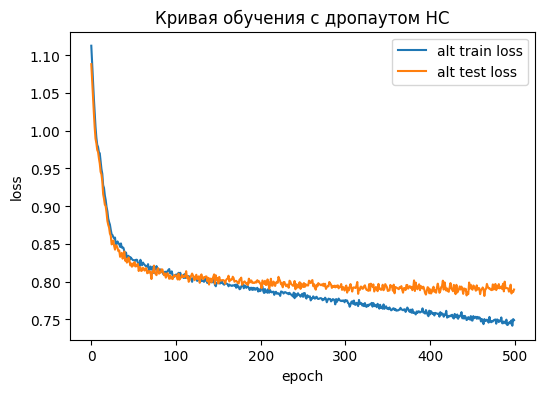

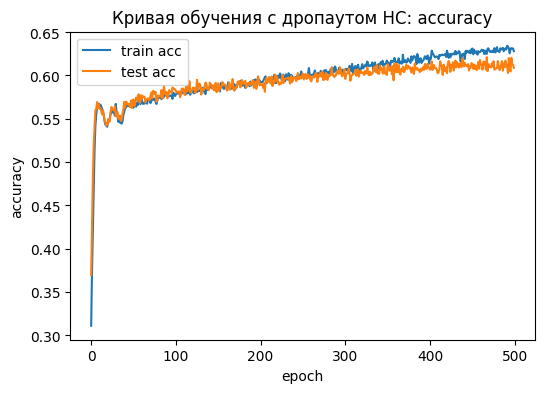

In [96]:

n1_alt = 256
n2_alt = 128
n3_alt = 65
act_alt = nn.LeakyReLU(negative_slope=0.01)

model_DP = NeuralNetworkDP(n_features, n1_alt, n2_alt, n3_alt, n_classes, act_alt).to(device)

criterion_DP = nn.CrossEntropyLoss().to(device)
optimizer_DP = torch.optim.Adam(model_DP.parameters(), lr=0.001)

n_epochs_DP = 500

train_losses_DP = []
test_losses_DP = []
train_accs_DP = []
test_accs_DP = []

for epoch in range(n_epochs_DP):
    logits_train_DP = model_DP(X2_train_t)
    loss_train_DP = criterion_DP(logits_train_DP, y2_train_t)

    optimizer_DP.zero_grad()
    loss_train_DP.backward()
    optimizer_DP.step()

    with torch.no_grad():
        logits_test_DP = model_DP(X2_test_t)
        loss_test_DP = criterion_DP(logits_test_DP, y2_test_t)

    train_losses_DP.append(loss_train_DP.item())
    test_losses_DP.append(loss_test_DP.item())
    _, train_pred_DP = torch.max(logits_train_DP, 1)
    _, test_pred_DP = torch.max(logits_test_DP, 1)
    train_acc_DP = (train_pred_DP == y2_train_t).float().mean().item()
    test_acc_DP = (test_pred_DP == y2_test_t).float().mean().item()
    train_accs_DP.append(train_acc_DP)
    test_accs_DP.append(test_acc_DP)

    if (epoch + 1) % 10 == 0:

        print(f"[ALT] Epoch {epoch+1}/{n_epochs_DP}, "
              f"train loss = {loss_train_DP.item():.4f}, "
              f"test loss = {loss_test_DP.item():.4f}, "
              f"train acc = {train_acc_DP:.3f}, "
              f"test acc = {test_acc_DP:.3f}")

with torch.no_grad():
    logits_test_DP = model_DP(X2_test_t)
    _, y2_pred_DP = torch.max(logits_test_DP, 1)
    acc_DP = (y2_pred_DP == y2_test_t).float().mean().item()

print(f"\nAccuracy для альтернативной архитектуры с дропаутом: {acc_DP:.3f}")

plt.figure(figsize=(6, 4))
plt.plot(train_losses_DP, label="alt train loss")
plt.plot(test_losses_DP, label="alt test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Кривая обучения c дропаутом НС")
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(train_accs_DP, label="train acc")
plt.plot(test_accs_DP, label="test acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Кривая обучения с дропаутом НС: accuracy")
plt.legend()
plt.show()

**Вопрос:** Какая архитектура нейронной сети оказалась наилучшей для решения данной задачи?

Особо большой разницы в точности не обнаружено

## Задача 3

Для удобного деления данных на батчи используйте *torch.utils.data.DataLoader* 

Это необходимо, поскольку зачастую невозможно все данные поместить на *GPU*

*batch_size* ограничен сверху оперативной паматью видеокарты, а снизу - тем, что тем меньше взять данных в батч, тем хуже будет обучение весов

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,  TensorDataset

In [10]:

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else :
    device = 'cpu'

print("Using device:", device)

Using device: mps


Загрузите датасет [МNIST](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)

In [4]:
# Преобразования: тензор + нормализация (стандартные для MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),  # [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # среднее и std по MNIST
])

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

batch_size = 128 

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


Постройте нейросеть и обучите её с разбиением на батчи. Постарайтесь добиться качества около 95%

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers_stack(x)
        return logits

In [17]:
model = NeuralNetwork().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 10  # где-то к 6-7 эпохе переваливает за 0.98 acc

In [18]:
train_losses = []
train_accs   = []
test_accs    = []

for epoch in range(n_epochs):
    # ------- train -------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)              # [batch, 10]
        loss = criterion(outputs, labels)    # CE по логитам
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # ------- eval -------
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = outputs.max(1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    test_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(
        f"Epoch {epoch+1}/{n_epochs} | "
        f"train_loss={train_loss:.4f} | "
        f"train_acc={train_acc:.4f} | "
        f"test_acc={test_acc:.4f}"
    )

Epoch 1/10 | train_loss=0.2821 | train_acc=0.9138 | test_acc=0.9646
Epoch 2/10 | train_loss=0.1254 | train_acc=0.9616 | test_acc=0.9721
Epoch 3/10 | train_loss=0.0959 | train_acc=0.9697 | test_acc=0.9769
Epoch 4/10 | train_loss=0.0779 | train_acc=0.9764 | test_acc=0.9802
Epoch 5/10 | train_loss=0.0691 | train_acc=0.9772 | test_acc=0.9790
Epoch 6/10 | train_loss=0.0617 | train_acc=0.9808 | test_acc=0.9810
Epoch 7/10 | train_loss=0.0538 | train_acc=0.9832 | test_acc=0.9813
Epoch 8/10 | train_loss=0.0510 | train_acc=0.9837 | test_acc=0.9808
Epoch 9/10 | train_loss=0.0489 | train_acc=0.9844 | test_acc=0.9830
Epoch 10/10 | train_loss=0.0459 | train_acc=0.9855 | test_acc=0.9810


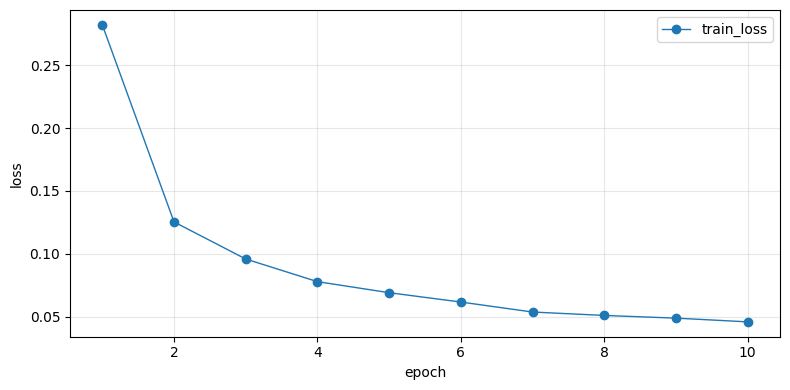

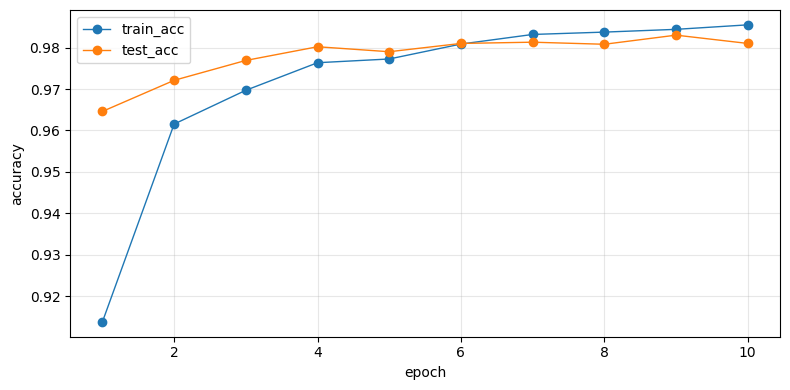

In [19]:
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(8,4))
plt.plot(epochs, train_losses, marker="o", linewidth=1, label="train_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=200, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, train_accs, marker="o", linewidth=1, label="train_acc")
plt.plot(epochs, test_accs,  marker="o", linewidth=1, label="test_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("acc_curves.png", dpi=200, bbox_inches="tight")
plt.show()

**Вопрос:** Какую архитектуру подобрали и на сколько батчей разбивали данные?

В качестве препроцессинга к каждому объекту применялась нормализация: после перевода из [0, 1] в тензор выполнялось преобразование
$x' = (x - \mu) / \sigma$ с параметрами $\mu = 0.1307, \sigma = 0.3081$, соответствующими среднему и стандартному отклонению по обучающему набору MNIST

## Задача 4

Важным математическим результатом теории нейросетей является [Теорема Цыбенко](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%A6%D1%8B%D0%B1%D0%B5%D0%BD%D0%BA%D0%BE), которая гласит, что для любой непрерывной функции можно подобрать веса нейросети с одним скрытым слоем и сигмоидальной функцией активации таким образом, чтобы сколько угодно точно приблизить её

В файле *signal_sample_1.csv* содержатся данные о физическом сигнале $X(t)$. Проверьте теорему Цыбенко на этих данных

In [4]:
import os

In [12]:
print(torch.backends.mps.is_available(), torch.backends.mps.is_built())

True True


In [6]:
df = pd.read_csv("signal_sample_1.csv")

# Берём только числовые колонки
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) < 2:
    raise ValueError(f"В CSV мало числовых колонок. Нашлось: {num_cols}")

t_col, x_col = num_cols[0], num_cols[1]
t = df[t_col].to_numpy().astype(np.float32)
x = df[x_col].to_numpy().astype(np.float32)

# на всякий случай сортировка по времени
idx = np.argsort(t)
t, x = t[idx], x[idx]

print("columns:", t_col, x_col, "| N:", len(t))

columns: t x | N: 59856


In [7]:
thr = np.quantile(x, 0.95)
print("share above 95%:", (x > thr).mean())

share above 95%: 0.05000334135257952


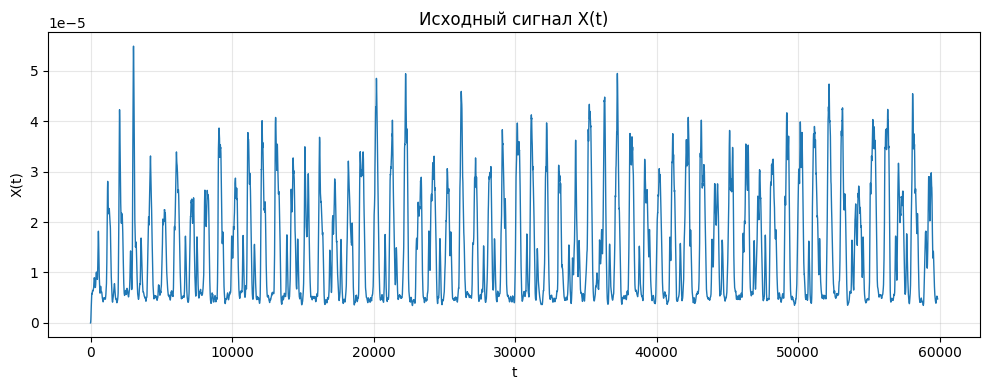

In [8]:
plt.figure(figsize=(10,4))
plt.plot(t, x, linewidth=1)
plt.title("Исходный сигнал X(t)")
plt.xlabel("t"); plt.ylabel("X(t)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# device (на M1)
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("device:", device)

N = len(t)
mask_test = (torch.arange(N) % 5 == 0)   # каждый 5-й в тест
mask_train = ~mask_test

x_work = np.log1p(x) 

# Нормировку считаем по TRAIN, чтобы не было утечки
t_train_np = t[mask_train.numpy()]
x_train_np = x_work[mask_train.numpy()]

t_mean, t_std = t_train_np.mean(), t_train_np.std() + 1e-8
x_mean, x_std = x_train_np.mean(), x_train_np.std() + 1e-8

t_n = (t - t_mean) / t_std
x_n = (x_work - x_mean) / x_std

T = torch.tensor(t_n[:, None], dtype=torch.float32, device=device)
Y = torch.tensor(x_n[:, None], dtype=torch.float32, device=device)

T_train, Y_train = T[mask_train.to(device)], Y[mask_train.to(device)]
T_test,  Y_test  = T[mask_test.to(device)],  Y[mask_test.to(device)]

# "сырые" значения для метрик
x_train_raw = x[mask_train.numpy()]
x_test_raw  = x[mask_test.numpy()]
t_test_np   = t[mask_test.numpy()]




device: mps


In [10]:
class OneHiddenSigmoid(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.act = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

In [24]:

def init_sigmoid_covering(model: OneHiddenSigmoid, T_train: torch.Tensor, w_scale: float = 10.0):
    """
    Инициализация 1-hidden sigmoid сети так, чтобы у каждой сигмоиды был свой "порог" (центр переключения) по t.
    model: OneHiddenSigmoid (fc1 -> sigmoid -> fc2)
    T_train: [N,1] нормированный t на нужном device
    w_scale: масштаб "резкости" (чем больше, тем уже переходы сигмоид)
    """
    with torch.no_grad():
        # размеры
        hidden = model.fc1.out_features
        device = model.fc1.weight.device

        # диапазон t (нормированный)
        t_min = T_train.min().item()
        t_max = T_train.max().item()

        # веса первого слоя: знаки случайные, модули ~ w_scale
        W = torch.randn_like(model.fc1.weight) * w_scale          # [hidden, 1]

        # центры переключения равномерно по t
        c = torch.linspace(t_min, t_max, hidden, device=device)   # [hidden]

        # bias так, чтобы W*t + b = 0 при t=c  => b = -W*c
        b = -(W[:, 0] * c)                                        # [hidden]

        model.fc1.weight.copy_(W)
        model.fc1.bias.copy_(b)

        # второй слой: маленький старт, чтобы не улететь в константу
        model.fc2.weight.normal_(mean=0.0, std=0.1)
        model.fc2.bias.zero_()


def weighted_mse(pred, target, weight):
    return (weight * (pred - target) ** 2).sum() / weight.sum()

def sharp_init_sigmoid(model, w_scale, b_scale):
    # Делаем сигмоиды "резче": увеличиваем веса первого линейного слоя
    with torch.no_grad():
        l1 = model.net[0]  # nn.Linear(1, hidden)
        l1.weight.mul_(w_scale)
        l1.bias.mul_(b_scale)

def train_model_fullbatch(hidden_size, T_train, Y_train, T_test, Y_test, x_train_raw, w_scale,
                          epochs=2000, lr=3e-3, alpha=500.0, print_every=200, device="cpu"):
    model = OneHiddenSigmoid(hidden_size).to(device)
    init_sigmoid_covering(model, T_train, w_scale=w_scale)

    opt = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=20, line_search_fn="strong_wolfe")


    q95 = np.quantile(x_train_raw, 0.95)
    w = np.ones_like(x_train_raw, dtype=np.float32)
    w[x_train_raw > q95] = 1.0 + alpha
    W = torch.tensor(w[:, None], dtype=torch.float32, device=device)

    for epoch in range(1, epochs + 1):
        def closure():
            opt.zero_grad()
            pred = model(T_train)
            loss = weighted_mse(pred, Y_train, W)
            loss.backward()
            return loss
    
        #loss = opt.step(closure)
        loss_val = opt.step(closure).item()

        if epoch % print_every == 0 or epoch == 1:
            print(f"epoch={epoch} | train_wmse={loss_val:.6f}")
            model.eval()
            with torch.no_grad():
                tr = nn.MSELoss()(model(T_train), Y_train).item()
                te = nn.MSELoss()(model(T_test),  Y_test ).item()
                wmse = weighted_mse(model(T_train), Y_train, W).item()
                mse  = nn.MSELoss()(model(T_train), Y_train).item()
                # обратно в x-шкалу
                pred_te_n = model(T_test)
                pred_te_log = pred_te_n * x_std + x_mean
                pred_te = torch.expm1(pred_te_log).detach().cpu().numpy().reshape(-1)
                
                true_te = torch.expm1(Y_test * x_std + x_mean).detach().cpu().numpy().reshape(-1)
                
                # маска "пики" по train-порогy
                thr = np.quantile(x_train_raw, 0.95)
                mask_peak = true_te > thr
                
                rmse_all  = np.sqrt(np.mean((pred_te - true_te) ** 2))
                rmse_peak = np.sqrt(np.mean((pred_te[mask_peak] - true_te[mask_peak]) ** 2)) if mask_peak.any() else np.nan
                mae_peak  = np.mean(np.abs(pred_te[mask_peak] - true_te[mask_peak])) if mask_peak.any() else np.nan
                
            print(f"rmse_all={rmse_all:.3e} | rmse_peak={rmse_peak:.3e} | mae_peak={mae_peak:.3e} | peak_share={mask_peak.mean():.3f}")
            
            print(f"h={hidden_size:4d} | w={w_scale:4.0f} | epoch={epoch:4d} | train_mse={tr:.6f} | test_mse={te:.6f}")
            print(f"wmse={wmse:.6f} | mse={mse:.6f}")

    return model, q95

In [25]:
hidden_list = [100, 200, 400, 700, 1000]
models = {}
w_sc_list =[5,10,20,50]

In [26]:

for h in hidden_list:
    for w in w_sc_list:
        print("\n--- training h =", h, "w_scale = ", w, "---")
        model_h, q95 = train_model_fullbatch(
            hidden_size=h,
            T_train=T_train, Y_train=Y_train,
            T_test=T_test,   Y_test=Y_test,
            x_train_raw=x_train_raw,
            epochs=600, lr=3e-3, alpha=500,
            device=device,
            w_scale=w
        )
        models[(h, w)] = (model_h, q95)


--- training h = 100 w_scale =  5 ---
epoch=1 | train_wmse=4.774436
rmse_all=2.666e-05 | rmse_peak=3.269e-06 | mae_peak=2.467e-06 | peak_share=0.051
h= 100 | w=   5 | epoch=   1 | train_mse=6.048691 | test_mse=6.049235
wmse=0.320441 | mse=6.048691
epoch=200 | train_wmse=0.238733
rmse_all=2.259e-05 | rmse_peak=2.936e-06 | mae_peak=2.299e-06 | peak_share=0.051
h= 100 | w=   5 | epoch= 200 | train_mse=4.341273 | test_mse=4.340936
wmse=0.238733 | mse=4.341273
epoch=400 | train_wmse=0.238733
rmse_all=2.259e-05 | rmse_peak=2.936e-06 | mae_peak=2.299e-06 | peak_share=0.051
h= 100 | w=   5 | epoch= 400 | train_mse=4.341273 | test_mse=4.340936
wmse=0.238733 | mse=4.341273
epoch=600 | train_wmse=0.238733
rmse_all=2.259e-05 | rmse_peak=2.936e-06 | mae_peak=2.299e-06 | peak_share=0.051
h= 100 | w=   5 | epoch= 600 | train_mse=4.341273 | test_mse=4.340936
wmse=0.238733 | mse=4.341273

--- training h = 100 w_scale =  10 ---
epoch=1 | train_wmse=2.341620
rmse_all=2.669e-05 | rmse_peak=3.297e-06 | ma

In [105]:
def rmse(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return np.sqrt(np.mean((a - b) ** 2))

# берём лучшую модель
best_h = 200
best_w = 50
best_model, q95 = models[(best_h, best_w)]

best_model.eval()
with torch.no_grad():
    pred_test_n = best_model(T_test).detach().cpu().numpy().reshape(-1)

pred_test = pred_test_n * x_std + x_mean
true_test = x_test_raw

mask_peak = true_test > q95
mask_bg = ~mask_peak

print("RMSE all :", rmse(true_test, pred_test))
print("RMSE peak:", rmse(true_test[mask_peak], pred_test[mask_peak]))
print("RMSE bg  :", rmse(true_test[mask_bg], pred_test[mask_bg]))

RMSE all : 2.0133222e-05
RMSE peak: 8.011573e-06
RMSE bg  : 2.0570022e-05


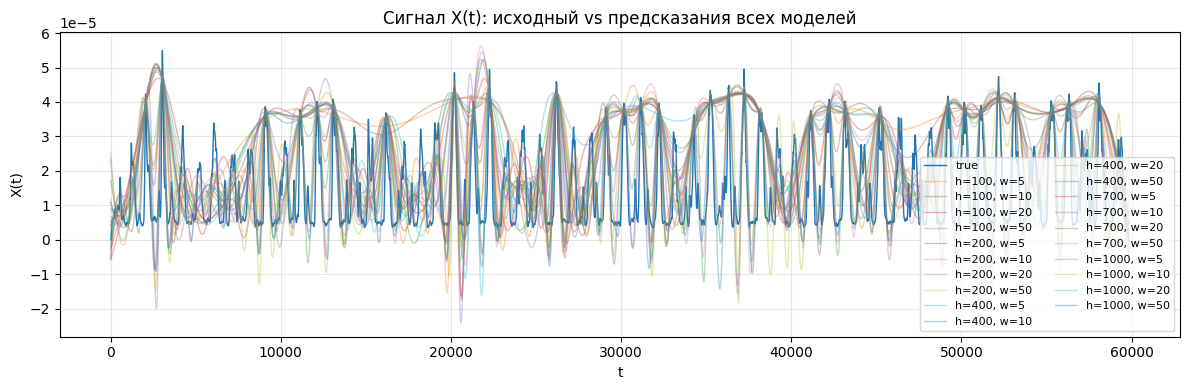

In [34]:
plt.figure(figsize=(12, 4))
plt.plot(t, x, label="true", linewidth=1)

for (h, w), (m, q95) in models.items():
    m.eval()
    with torch.no_grad():
        pred_all_n = m(T).detach().cpu().numpy().reshape(-1)

    pred_all_log = pred_all_n * x_std + x_mean
    pred_all = np.expm1(pred_all_log)

    plt.plot(t, pred_all, linewidth=1, alpha=0.35, label=f"h={h}, w={w}")

plt.title("Сигнал X(t): исходный vs предсказания всех моделей")
plt.xlabel("t"); plt.ylabel("X(t)")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
out_path = "signal_all_models.png"
plt.savefig(out_path, dpi=600, bbox_inches="tight")
plt.show()

Визуализируйте сигнал и подобранную нейросетью функцию

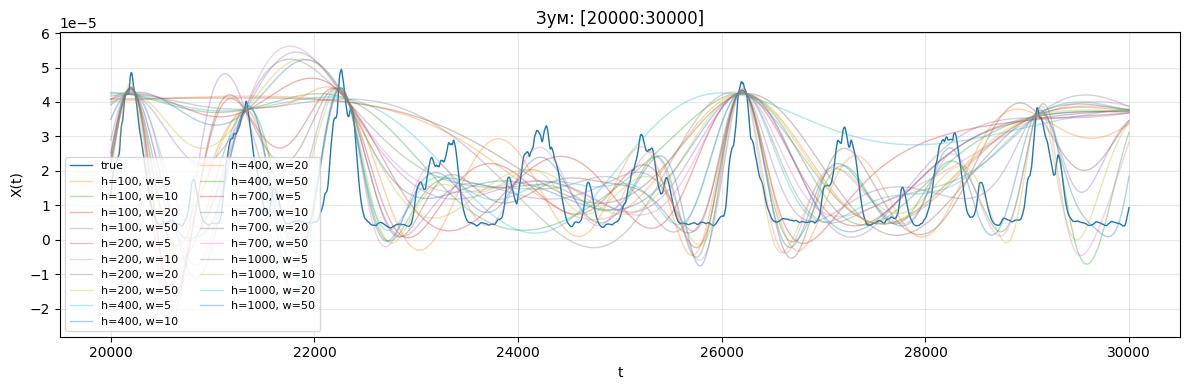

In [39]:
i0, i1 = 20000, 30000

plt.figure(figsize=(12, 4))
plt.plot(t[i0:i1], x[i0:i1], label="true", linewidth=1)
for (h, w), (m, q95) in models.items():
    m.eval()
    with torch.no_grad():
        pred_all_n = m(T).detach().cpu().numpy().reshape(-1)

    pred_all_log = pred_all_n * x_std + x_mean
    pred_all = np.expm1(pred_all_log)

    plt.plot(t[i0:i1], pred_all[i0:i1], linewidth=1, alpha=0.35, label=f"h={h}, w={w}")

plt.title(f"Зум: [{i0}:{i1}]")
plt.xlabel("t"); plt.ylabel("X(t)")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
out_path = "signal_all_models_crop.png"
plt.savefig(out_path, dpi=600, bbox_inches="tight")
plt.show()

In [35]:


def inv_scale(pred_n, x_mean, x_std):
    # pred_n: torch [N,1] в нормированной шкале log1p
    pred_log = pred_n * x_std + x_mean
    return torch.expm1(pred_log)  # обратно в x-шкалу

thr = np.quantile(x_train_raw, 0.95)  # порог пиков по train

rows = []
for (h, w), (m, _) in models.items():
    m.eval()
    with torch.no_grad():
        pred_te_n = m(T_test)          # torch [N,1] (на device)
        pred_te = inv_scale(pred_te_n, x_mean, x_std).detach().cpu().numpy().reshape(-1)
        true_te = inv_scale(Y_test,    x_mean, x_std).detach().cpu().numpy().reshape(-1)

    mask_peak = true_te > thr
    rmse_all  = np.sqrt(np.mean((pred_te - true_te) ** 2))
    rmse_peak = np.sqrt(np.mean((pred_te[mask_peak] - true_te[mask_peak]) ** 2)) if mask_peak.any() else np.nan
    mae_peak  = np.mean(np.abs(pred_te[mask_peak] - true_te[mask_peak])) if mask_peak.any() else np.nan

    rows.append(dict(h=h, w=w, rmse_all=rmse_all, rmse_peak=rmse_peak, mae_peak=mae_peak, peak_share=mask_peak.mean()))

df = pd.DataFrame(rows)

# сортировка "сначала пики, потом всё"
df_sorted = df.sort_values(["rmse_peak", "rmse_all"], ascending=[True, True])
display(df_sorted.head(10))

best = df_sorted.iloc[0]
print("BEST:", best.to_dict())

,h,w,rmse_all,rmse_peak,mae_peak,peak_share
19,1000,50,0.000007,0.000002,0.000001,0.050869
15,700,50,0.000008,0.000002,0.000001,0.050869
11,400,50,0.000009,0.000002,0.000002,0.050869
7,200,50,0.000011,0.000002,0.000002,0.050869
14,700,20,0.000015,0.000002,0.000002,0.050869
3,100,50,0.000016,0.000002,0.000002,0.050869
18,1000,20,0.000017,0.000002,0.000002,0.050869
10,400,20,0.000018,0.000002,0.000002,0.050869
6,200,20,0.000018,0.000002,0.000002,0.050869
2,100,20,0.000019,0.000002,0.000002,0.050869


BEST: {'h': 1000.0, 'w': 50.0, 'rmse_all': 7.417120286845602e-06, 'rmse_peak': 1.995688535316731e-06, 'mae_peak': 1.4453881931331125e-06, 'peak_share': 0.05086869361844303}


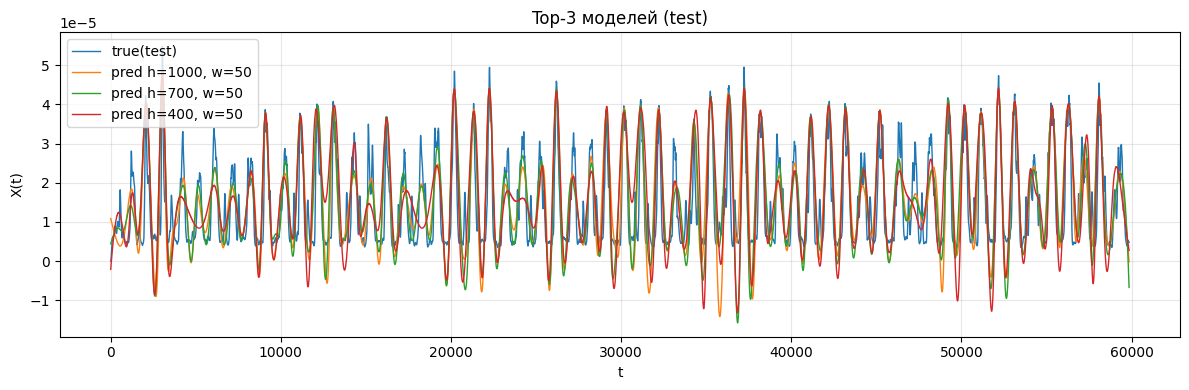

In [37]:
topk = 3
top = df_sorted.head(topk)[["h","w"]].to_records(index=False)

plt.figure(figsize=(12,4))
plt.plot(t[mask_test.numpy()], x[mask_test.numpy()], label="true(test)", linewidth=1)

for h, w in top:
    m, _ = models[(int(h), int(w))]
    m.eval()
    with torch.no_grad():
        pred_te_n = m(T_test)
        pred_te = inv_scale(pred_te_n, x_mean, x_std).detach().cpu().numpy().reshape(-1)
    plt.plot(t[mask_test.numpy()], pred_te, linewidth=1, label=f"pred h={h}, w={w}")

plt.title(f"Top-{topk} моделей (test)")
plt.xlabel("t"); plt.ylabel("X(t)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("top-models.png", dpi=600, bbox_inches="tight")
plt.show()

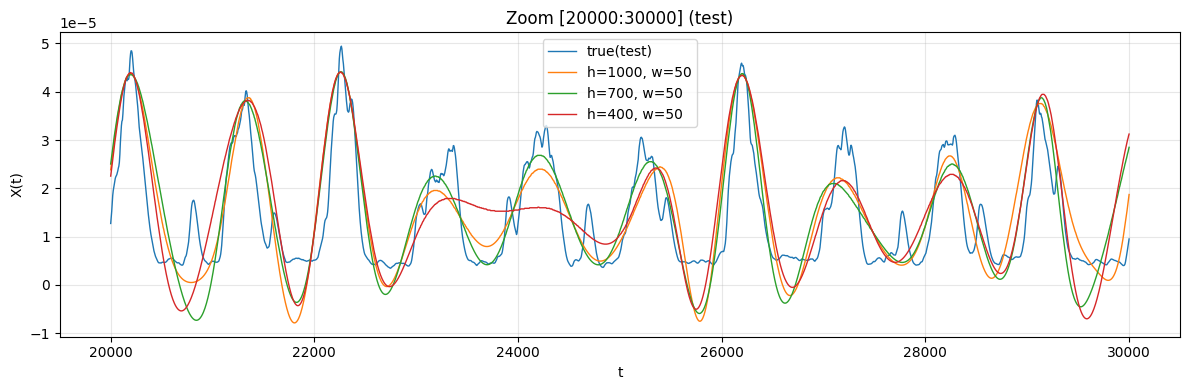

In [41]:
t_test = t[mask_test.numpy()]
x_test = x[mask_test.numpy()]
# окно, где много пиков

win = (t_test >= i0) & (t_test <= i1)

plt.figure(figsize=(12,4))
plt.plot(t_test[win], x_test[win], label="true(test)", linewidth=1)

for h, w in top:
    m, _ = models[(int(h), int(w))]
    m.eval()
    with torch.no_grad():
        pred_te_n = m(T_test)
        pred_te = inv_scale(pred_te_n, x_mean, x_std).detach().cpu().numpy().reshape(-1)
    plt.plot(t_test[win], pred_te[win], linewidth=1, label=f"h={h}, w={w}")

plt.title(f"Zoom [{i0}:{i1}] (test)")
plt.xlabel("t"); plt.ylabel("X(t)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("top-models-crop.png", dpi=600, bbox_inches="tight")
plt.show()

**Вопрос:** С какой точностью получилось восстановить функцию сигнала?

Доля пиков (верхние 5%): peak_share ≈ 0.05

Топовая конфигурация:

- h=1000, w_scale=50:
- rmse_all $\approx$ 7.417e-06
- rmse_peak $\approx$ 1.996e-06
- mae_peak $\approx$ 1.445e-06

**По пикам** ошибка порядка $2\cdot 10^{-6}$, то есть модель пики приближает (хотя визуально может сглаживать/перезванивать).

**По всем точкам** ошибка порядка $7.4\cdot 10^{-6}$, что отражает, что базовая часть сигнала и мелкие колебания тоже не идеальны.